In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

data_bulk = pd.read_csv('/mnt/data1/weixu/HiDe/spicemix/ENIGMA_py/Bulk.csv',delimiter=',', index_col=0).transpose()
idCell = pd.read_csv('/mnt/data1/weixu/HiDe/spicemix/ENIGMA_py/idCell.csv',delimiter=',', index_col=0)
ref = pd.read_csv('/mnt/data1/weixu/HiDe/spicemix/ENIGMA_py/ref.csv',delimiter=',', index_col=0)

In [2]:
adata = ad.AnnData(data_bulk, obs=idCell)
adata

AnnData object with n_obs × n_vars = 200 × 8368
    obs: 'Fibroblast', 'CellType2', 'CellType3'

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.0 anndata==0.7.5 umap==0.4.6 numpy==1.18.5 scipy==1.6.2 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6 pynndescent==0.5.1


In [4]:
sc.tl.pca(adata, svd_solver='arpack') # calculate top50 pca
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40) # calculate neighborhood graph
sc.tl.umap(adata) # running UMAP
adata

computing PCA
    with n_comps=50
    finished (0:00:08)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


AnnData object with n_obs × n_vars = 200 × 8368
    obs: 'Fibroblast', 'CellType2', 'CellType3'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

... storing 'Fibroblast' as categorical
... storing 'CellType3' as categorical


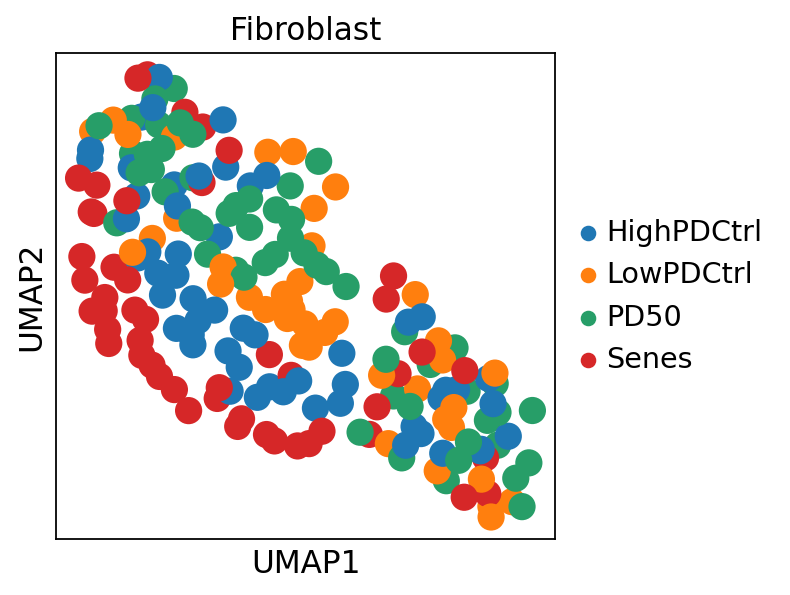

In [5]:
sc.pl.umap(adata, color=['Fibroblast'])

In [6]:
import scipy
from combat.pycombat import pycombat
import autogenes as ag
import torch
import numpy as np
import qnorm
from scvelo import logging

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
    
def aggre(ref,meta_ref,var_infor,label,hvg=True):
    ref_mat = np.zeros([ref.shape[0],len(meta_ref[label].values.categories.values)])
    for i in range(len(meta_ref[label].values.categories.values)):
        ct = meta_ref[label].values.categories.values[i]
        re = ref[:,meta_ref[label].values == ct].mean(1)
        ref_mat[:,i] += re
        rownames = var_infor.index.values
        
    if hvg:
        feature = var_infor.index[var_infor.highly_variable_genes.values == "True"].values
        ref_mat = ref_mat[var_infor.highly_variable_genes.values == "True",:]
        rownames = feature
        
    colnames = meta_ref[label].values.categories.values
    ref_mat = pd.DataFrame(ref_mat, columns=colnames, index=rownames)
    return ref_mat

class ENIGMA:
    def __init__(
        self, bulk_data,ref, ref_type,label,
        hvg,device,ncores
    ):
        ## transfer the np.array format data into sparse matrix
        if ref_type != "signature":
            meta_ref = []
            genes = ref.var.index.values
            samples = ref.obs.index.values
            
            if ref_type == "single_cell":
                ## the reference data is from AnnData object
                meta_ref = ref.obs
                ref_m = []
                
            if ref_type == "aggre":
                meta_ref = ref.obs
                var_infor = ref.var
                ref = ref.X.transpose()
                ref_m = aggre(ref,meta_ref,var_infor,label,hvg=hvg)
            
            ### processing bulk datasets
            genes_css = intersection(genes, bulk_data.index)
            bulk_data = bulk_data.loc[genes_css,:]
            if ref_type != "single_cell": ref_m = ref_m.loc[genes_css,:]
            if ref_type == "single_cell": 
                ref = ref[:,genes_css]
                ref = ref.X.transpose()  
        
        if ref_type == "signature":
            meta_ref = []
            samples = []
            ref_m = ref
            genes_css = intersection(ref_m.index, bulk_data.index)
            bulk_data = bulk_data.loc[genes_css,:]
            ref_m = ref_m.loc[genes_css,:]
            
        genes = genes_css 
        self.Bulk = bulk_data
        self.ref_m = ref_m
        self.ref = ref
        self.meta_ref = meta_ref
        self.genes = genes
        self.samples = samples
        self.ref_type = ref_type
        self.remove_batch_effects = []
        self.device = device
        self.ncores = ncores
        
    def remove_batch_effects(self,theta):
        if self.ref_type == "single_cell":
            logging.info("Using S_mode to correct batch effects...")
            self.ref_m,self.Bulk = S_mode_correction(self)
        if self.ref_type != "single_cell":
            logging.info("Using B_mode to correct batch effects...")
            self.Bulk = B_mode_correction(self)    
            
    def get_cell_proportions(self,FSelect = True,optimize=True):
        if FSelect:
            ag.init(self.ref_m.T)
            ag.optimize(ngen=5000,seed=0,nfeatures=400,mode='fixed',offspring_size=100,verbose=False)
            ag.plot(weights=(-1,0))
            index = ag.select(index=0)
            self.fgenes = self.ref_m.index[index].values
        
        #######
        # estimate the abundance
        logging.info("Using robust linear regression model to infer cell type proportions")
        Y = np.array(self.Bulk.loc[self.genes,:])
        X = np.array(self.ref_m.loc[self.genes,:])
        X_scale = np.zeros(X.shape)
        for it in range(X_scale.shape[1]):
            X_scale[:,it] = (X[:,it] - X[:,it].mean())/np.sqrt(np.var(X[:,it])*(X.shape[0]/(X.shape[0]-1)))
        frac_m = np.zeros([Y.shape[1],X.shape[1]])
        for i in range(Y.shape[1]):
            y = Y[:,i]
            if optimize:
                parlist = optimize_para([1.35,0.0001],X,y)
                model = HuberRegressor(epsilon=parlist[0],alpha=parlist[1])
            else:
                model = HuberRegressor()
            model.fit(X,y)
            coef = model.coef_
            coef = np.maximum(coef,0)
            coef = coef / sum(coef)
            frac_m[i,:] = coef
        
        sample_names = self.Bulk.columns
        ct_names = self.ref_m.columns
        frac_m = pd.DataFrame(frac_m, columns=ct_names, index=sample_names)
        
        self.frac_m = frac_m
    
    def run_enigma(self,alpha=0.5,beta=0.1,epsilon=0.001,lr = 1e-1,max_iter=1000,pos=True,normalize=True,norm_method="frac",preprocess="sqrt"):
        
        ###estimate model parameters for ENIGMA
        ##preparing datasets
        X = np.array(self.Bulk)
        theta = np.array(self.frac_m)
        R = np.array(self.ref_m)
        dtype = torch.float
        device = self.device 
        
        if preprocess == "sqrt":
            X = np.sqrt(X)
            R = np.sqrt(R)
            
        if preprocess == "log":
            X = np.log(X)
            R = np.log(R)
            
        assert preprocess == "log" or preprocess == "sqrt" or preprocess == "raw"
        assert norm_method == "frac" or norm_method == "quantile"
        
        #Convert X into tensor objects
        X = torch.tensor(X, dtype=dtype, device=device)
        #initialization
        logging.info("Initialization")
        P = []
        for i in range(R.shape[1]):
            P.append(torch.tensor(np.zeros(X.shape), dtype=dtype, device=device))
        P_new = []
        for i in range(R.shape[1]):
            P_new.append(torch.tensor(np.zeros(X.shape), dtype=dtype, device=device))
        ### create tensor
        stop_flag = False
        __t__ = 1
        #optimizer = torch.optim.Adam(P, lr=lr)
        #schedular = torch.optim.lr_scheduler.StepLR(optimizer,step_size=100, gamma=0.99)
        logging.info("Start Training...")
        for iiter in range(1, max_iter+1):
            
            ## initialize the gradient
            dP = grad(X,theta,P,R,alpha,device)
            for ct_i in range(0,len(P)):
                # initialization
                P[ct_i].grad = torch.zeros_like(P[ct_i])
                P[ct_i].grad.add_(dP[ct_i])
                P_new[ct_i] = proximalpoint(P[ct_i],lr,beta*1e5)
                        
            score = StopMetric(P_new,P)
            logging.info(f'Ratio ranges from:{min(score)} - {max(score)}')
            
            __t__ += 1
            
            if max(score) <= epsilon:
                stop_flag = True
            
            if __t__ >= max_iter:
                stop_flag = True
            
            if not stop_flag:
            #    optimizer.step()
            #    schedular.step()
                P = P_new.copy()
            
            if stop_flag: break
        
        logging.info(f'Converge in {__t__} steps')
        logging.info(f'Perform Normalization...')
        
        for ct_i in range(0,len(P)):
            # initialization
            P[ct_i] = np.maximum(P[ct_i],0)
            
        P_norm = P.copy()
        for i in range(len(P)):
            if preprocess == "log":
                P[i] = np.exp(P[i])-1
            if preprocess == "sqrt":
                P[i] = P[i]**2
                
            if norm_method == "frac":
                props = theta[:,i].reshape(theta.shape[0],1)
                den = P[i] @ props - (len(props)*props.mean()*P[i].mean(1)).reshape(P[i].shape[0],1)
                dev = sum(props**2) - len(props)*props.mean()**2
                GEP = P[i] - den/dev @ props.transpose()
                P_norm[i] = GEP
                
            if norm_method == "quantile":
                df = qnorm.quantile_normalize(P[0].detach().numpy(),ncpus=self.ncores)
                df = torch.tensor(df,dtype = dtype, device = device)
                P_norm[i] = df
        
        self.CSE_normalized = P_norm
        self.CSE = P

In [7]:
egm = ENIGMA(data_bulk.transpose(),ref,ref_type="signature",device="cpu",ncores=4,label=[],hvg=[])

In [8]:
from collections import Counter
from random import choices
import multiprocessing
import matplotlib.pyplot as plt
from scipy.optimize import nnls
from combat.pycombat import pycombat
from sklearn.linear_model import HuberRegressor
import scipy.stats as stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from scipy.optimize import minimize 
from scipy.optimize import LinearConstraint

def evaluate_func(parlist,X,y):
    epsilon = parlist[0]
    alpha = parlist[1]
    
    model = HuberRegressor(epsilon=epsilon,alpha=alpha)
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    return abs(scores.mean())
    
def optimize_para(parlist,X,y):
    
    #set constraint
    A = np.identity(2)
    lb = [1,0]
    ub = [np.inf,np.inf]
    cons = LinearConstraint(A, lb, ub, keep_feasible=False)
    
    #optimize
    result = minimize(evaluate_func,x0=parlist,args=(X, y), method="nelder-mead",constraints=cons)
    return result.x

In [9]:
## In pyENIGMA, we used nelder-mead method to optimize parameters of regression model
egm.get_cell_proportions(FSelect = False)

Using robust linear regression model to infer cell type proportions


In [10]:
egm.frac_m

,Fibroblast,CellType2,CellType3
Sample-1,0.407196,0.423546,0.169258
Sample-2,0.103231,0.171084,0.725684
Sample-3,0.531254,0.267266,0.201479
Sample-4,0.059238,0.091609,0.849153
Sample-5,0.345021,0.280377,0.374602
...,...,...,...
Sample-196,0.080464,0.299923,0.619613
Sample-197,0.348197,0.271519,0.380283
Sample-198,0.104995,0.041768,0.853238
Sample-199,0.181486,0.513190,0.305324


## Using maximum L2 norm model to perform deconvolution

In [11]:
## import functions

def ident(vec):
    m = np.zeros([len(vec),len(vec)])
    for (i,j) in zip(range(len(vec)),range(len(vec))):
        m[i,j] = vec[i]
    return m

def diag(vec):
    m = np.zeros([len(vec),len(vec)])
    for (i,j) in zip(range(len(vec)),range(len(vec))):
        m[i,j] = vec[i]
    return m

def grad(X,theta,P_old, R, alpha,device):
    dP1 = []
    for i in range(R.shape[1]):
        dP1.append(torch.zeros([X.shape[0],X.shape[1]], dtype=torch.float, device=device,requires_grad=False))
    
    dP2 = dP1.copy()
    
    for cell_type_index in range(0,len(dP1)):
        R_m = R[:,cell_type_index]
        
        cell_type_seq = np.array(range(len(P_old)))
        cell_type_seq = cell_type_seq[cell_type_seq!=cell_type_index]
        
        X_summary = torch.zeros([X.shape[0],X.shape[1]], dtype=torch.float, device=device,requires_grad=False)
        for i in cell_type_seq:
            X_summary += P_old[i] @ diag(theta[:,i])
        X_summary = X - X_summary
        
        dP1[cell_type_index] = 2*(P_old[cell_type_index] @ diag(theta[:,cell_type_index]) - X_summary) @ diag(theta[:,cell_type_index])
        dP1[cell_type_index] = torch.tensor(dP1[cell_type_index],dtype=torch.float, device=device,requires_grad=False)
        dP2_m1 = np.matrix(2*(P_old[cell_type_index].mean(1) - R[:,cell_type_index])).transpose()
        dP2_m2 = np.repeat(1/theta.shape[0],theta.shape[0]).reshape(1,theta.shape[0])
        dP2[cell_type_index] = dP2_m1 @ dP2_m2
        dP2[cell_type_index] = torch.tensor(dP2[cell_type_index],dtype=torch.float, device=device,requires_grad=False)
    
    dims = dP1[0].shape[0] * dP1[0].shape[1]
    norm_factor1 = torch.tensor([0],dtype=torch.float, device=device,requires_grad=False)
    for i in range(len(dP1)): norm_factor1 += sum(dP1[i].reshape(1,dims) * dP1[i].reshape(1,dims)).sum()
    norm_factor1 = np.sqrt(norm_factor1)
    
    norm_factor2 = torch.tensor([0],dtype=torch.float, device=device,requires_grad=False)
    for i in range(len(dP1)): norm_factor2 += sum(dP2[i].reshape(1,dims) * dP2[i].reshape(1,dims)).sum()
    norm_factor2 = np.sqrt(norm_factor2)

    for i in range(len(dP1)): dP1[i] = dP1[i]*1e5/norm_factor1.item()
    for i in range(len(dP2)): dP2[i] = dP2[i]*1e5/norm_factor2.item()
    
    dP = dP1.copy()
    for i in range(len(dP1)): dP[i] = alpha*dP1[i] + (1-alpha)*dP2[i]
    
    return dP
    

def proximalpoint(P,tao_k,beta,device="cpu"):
    V = P - tao_k*P.grad
    V = V.t()
    V = V.detach().numpy()
    V = torch.tensor(V,dtype=torch.float,device = device,requires_grad=False)
    P_hat = squash(V,tao_k*beta)
    P_hat = P_hat.t()
    #grad_new = (P - P_hat)/tao_k
    
    return P_hat

def StopMetric(P_new,P):
    score = []
    for i in range(len(P)):
        D = (P_new[i] - P[i])**2
        score.append(D.sum().item())
    
    return score

def squash(V,beta):
    M = V.clone()
    ## squash: calculate the optimal solution of the formula: X=argmin{ (||X-V||_F)^2 + beta*||X||_2_max }
    n = []
    for i in range(V.shape[0]):
        n.append(np.sqrt(sum(V[i,:]*V[i,:])))
    n = np.array(n)
    pi = torch.sort(torch.tensor(n),descending=True).indices
    s = []
    for i in range(len(pi)):
        i = i+1
        s.append(n[pi[0:i]].sum())
    s = np.array(s)
    dev = (np.array(range(len(s)))+1)+beta
    s_n = s/dev
    q = (np.array(range(len(n)))+1)[n[pi]>=s_n]
    q = q.max()
    tao = s[q-1]/(q+beta)
    for i in range(q):
        M[pi[i],:] = tao*M[pi[i],]/np.sqrt(sum(M[pi[i],:]*M[pi[i],:]))      
    return M
    

In [12]:
egm.run_enigma(alpha=0.1,lr=0.01,max_iter = 100,norm_method="frac")

Initialization
Start Training...
Ratio ranges from:135123.4375 - 140605.078125
Ratio ranges from:59947.6484375 - 60872.21484375
Ratio ranges from:26329.4453125 - 26534.48828125
Ratio ranges from:11445.9404296875 - 11698.8779296875
Ratio ranges from:5009.34765625 - 5134.60009765625
Ratio ranges from:2199.916748046875 - 2247.191162109375
Ratio ranges from:966.0667114257812 - 982.93115234375
Ratio ranges from:423.915771484375 - 430.0394287109375
Ratio ranges from:185.97012329101562 - 188.1793975830078
Ratio ranges from:81.578369140625 - 82.364990234375
Ratio ranges from:35.79454040527344 - 36.060585021972656
Ratio ranges from:15.707574844360352 - 15.791216850280762
Ratio ranges from:6.894026756286621 - 6.918529033660889
Ratio ranges from:3.027878522872925 - 3.0309629440307617
Ratio ranges from:1.327807068824768 - 1.3294401168823242
Ratio ranges from:0.58210688829422 - 0.5844428539276123
Ratio ranges from:0.2554338872432709 - 0.25663483142852783
Ratio ranges from:0.11205130815505981 - 0.11

In [13]:
GEP = pd.DataFrame(np.array(egm.CSE_normalized[0]), columns=data_bulk.index, index=data_bulk.columns).transpose()
GEP

,A4GALT,AAAS,AACS,AAED1,AAGAB,AAK1,AAMDC,AAMP,AAR2,AARD,...,ZSWIM6,ZSWIM7,ZSWIM8,ZUFSP,ZW10,ZWILCH,ZYG11B,ZYX,ZZEF1,ZZZ3
Sample-1,0.142025,0.076806,-0.007455,0.067449,0.168720,0.257553,0.264085,0.431212,0.038667,0.331628,...,0.170258,0.104900,0.025824,0.120618,0.020763,0.111681,0.666126,0.981192,0.076105,0.138640
Sample-2,0.086499,0.083815,0.016853,0.132603,0.216377,0.307668,0.300419,0.297162,0.078542,0.282625,...,0.190730,0.155189,0.054649,0.104751,0.001929,0.162189,0.445844,1.051112,0.028844,0.203276
Sample-3,0.042471,0.048481,-0.015362,0.150267,0.262630,0.249606,0.407789,0.234521,0.144091,0.380316,...,0.268178,0.085854,0.016510,0.170143,0.039742,0.145505,0.412175,1.121345,0.009175,0.112154
Sample-4,0.089409,0.078759,0.020200,0.124747,0.213915,0.311314,0.306893,0.343835,0.089298,0.296803,...,0.188067,0.168250,0.070472,0.110123,0.001784,0.200443,0.434822,1.095111,0.031039,0.201168
Sample-5,0.147291,0.134041,-0.000336,0.167692,0.297704,0.266958,0.372554,0.298053,0.134389,0.282914,...,0.189775,0.198369,0.081694,0.071985,-0.012918,0.148181,0.378787,1.006577,0.074538,0.215290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample-196,0.092349,0.092989,0.023557,0.121529,0.212528,0.305799,0.303130,0.324002,0.102540,0.287501,...,0.205859,0.184287,0.050018,0.141529,0.000470,0.182925,0.448676,1.066209,0.030568,0.181888
Sample-197,0.064724,0.130088,0.000957,0.088532,0.179528,0.265847,0.392287,0.346339,0.080763,0.290876,...,0.166367,0.221545,0.040154,0.128412,0.039894,0.118156,0.365469,0.984041,0.018881,0.196671
Sample-198,0.115483,0.065763,0.016525,0.120270,0.265637,0.301161,0.299246,0.301087,0.070063,0.315114,...,0.176656,0.156327,0.051323,0.116052,-0.002913,0.207504,0.426710,1.047349,0.040987,0.219895
Sample-199,0.079843,0.062089,0.037574,0.149959,0.275033,0.338466,0.284918,0.343958,0.090755,0.304687,...,0.215509,0.147586,0.077596,0.095257,-0.006630,0.151914,0.408890,1.163134,0.033381,0.162937


In [14]:
adata2 = ad.AnnData(GEP, obs=idCell)
sc.tl.pca(adata2, svd_solver='arpack') # calculate top50 pca
sc.pp.neighbors(adata2, n_neighbors=10, n_pcs=30) # calculate neighborhood graph
sc.tl.umap(adata2) # running UMAP

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


... storing 'Fibroblast' as categorical
... storing 'CellType3' as categorical


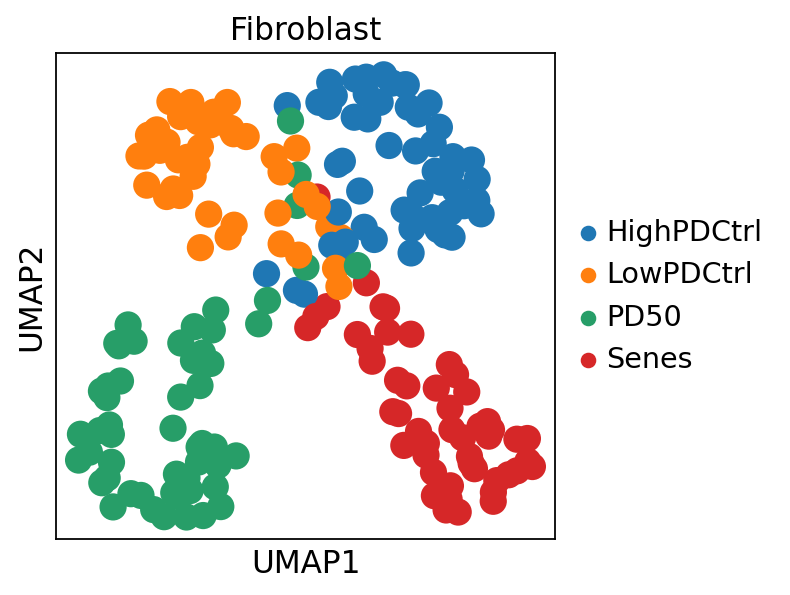

In [15]:
sc.pl.umap(adata2, color=['Fibroblast'])